In [109]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(20,15),"font.size":20,"axes.titlesize":20,"axes.labelsize":20})

from timeit import default_timer as timer
import math
from decimal import Decimal

from IPython.display import display

import scipy.optimize as opt

from autograd import jacobian

In [5]:
#A counter class accepts callback function
class Counter:
    def __init__(self,cb):
        self.counter=0
        self.callback=cb

    def __call__(self, *args):
        self.counter+=1
        return self.callback(*args)

    def value(self):
        return self.counter
    
    def reset(self):
        self.counter=0

In [3]:
#random numbers with noise yk=alpha*xk+beta+deltak
np.random.seed(64733)

alpha = np.random.uniform(0,1,1)
beta = np.random.uniform(0,1,1)
print(alpha)
print(beta)
#100 numbers
x = np.linspace(0, 1, 101)
print(x)
#101 samples from the “standard normal” distribution
deltak = np.random.randn(101)
print(deltak)

yk_original=alpha * x + beta
yk = yk_original + deltak

yk

[0.2675422]
[0.37526551]
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]
[ 0.61958651 -1.24497183 -1.61494038 -0.06735567 -0.3638705  -0.47388826
 -0.56249627 -0.16288594  1.27547929 -0.57866363  1.22625976  0.60100489
 -0.13537565 -0.09979554  1.19630569 -0.43041775  2.06166007  0.53114731
 -1.0279474  -1.08855749  1.10415848  1.14607219 -0.4469196  -0.99498726
  0.91963862 -2.13257778  1.63346207 -1.11005467  0.34223636  0.59545807
 -0.35329138  0.20317091  0.20666921  0.29229901  0.14525975  0.29950287
 -0.76791736  1.3118183

array([ 0.99485202, -0.8670309 , -1.23432402,  0.3159361 ,  0.0220967 ,
       -0.08524565, -0.17117822,  0.23110753,  1.67214817, -0.17931932,
        1.62827949,  1.00570004,  0.27199492,  0.31025046,  1.60902711,
       -0.01502092,  2.47973233,  0.95189499, -0.6045243 , -0.66245896,
        1.53293243,  1.57752157, -0.0127948 , -0.55818704,  1.35911425,
       -1.69042672,  2.07828855, -0.66255277,  0.79241369,  1.04831081,
        0.10223679,  0.6613745 ,  0.66754822,  0.75585344,  0.61148961,
        0.76840815, -0.29633666,  1.7860745 ,  0.37598844, -0.13671275,
        2.13020306, -0.39137689,  1.6131151 ,  1.88242013,  1.18357856,
        2.15323996,  0.56856512,  0.53703553,  2.02148664, -0.93127908,
       -0.06187185,  1.73643391,  1.44792277,  2.40006971,  0.3270609 ,
        0.85720829,  0.13339459,  2.41272663,  0.59588265,  0.85789509,
        1.62054499,  0.71131859,  0.52176788,  0.37411047, -1.80517123,
        2.08133493,  0.71664268,  1.66532017,  1.38765068,  1.43

<AxesSubplot:>

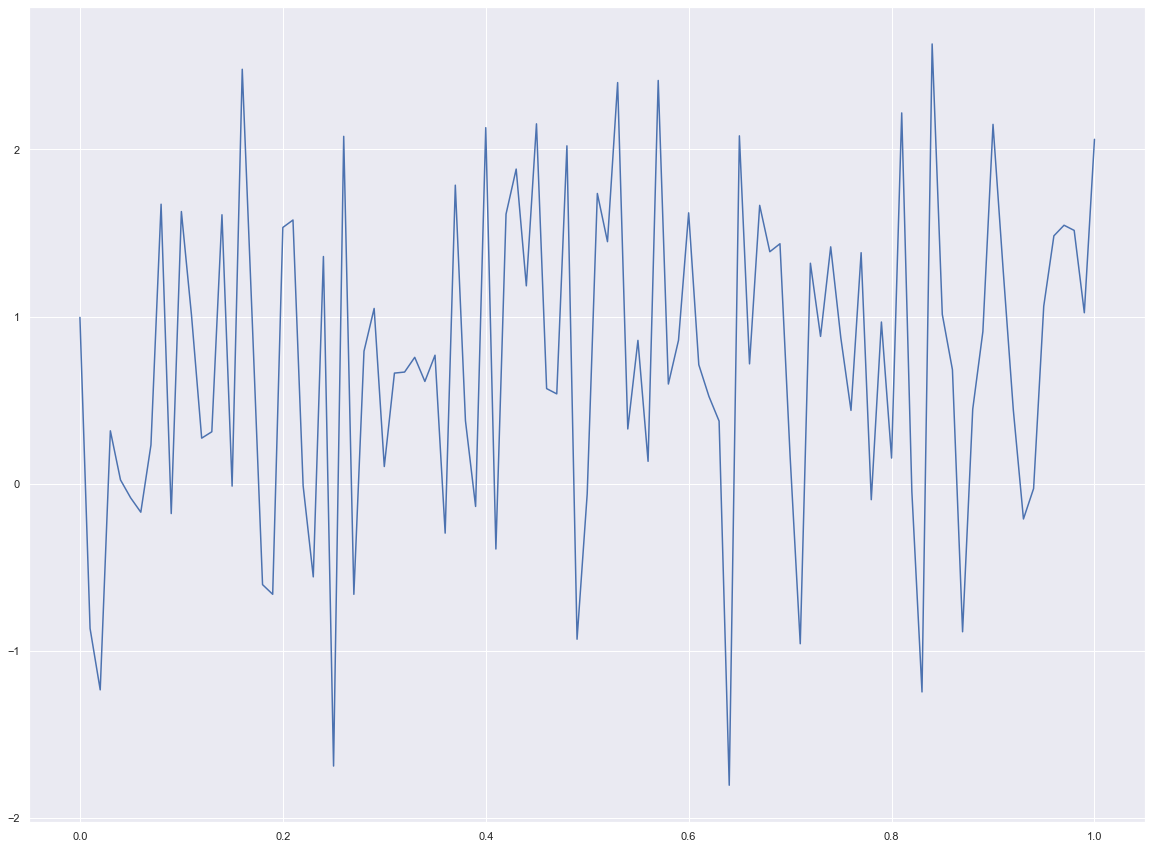

In [4]:
sns.lineplot(y=yk,x=x)

In [106]:
def linearSingle(x,a,b):
    return a*x+b

def rationalSingle(x,a,b):
    return a/(1+b*x)

def linear(x,a,b):
    return list(map(lambda x:linearSingle(x,a,b),x))

def rational(x,a,b):
    return list(map(lambda x:rationalSingle(x,a,b),x))

def sum_squares(params, y, x, f):
    a = params[0]
    b = params[1]
    return sum((y - f(x, a, b))**2)

#vector of difference
def diff(params, y, x, f):
    a = params[0]
    b = params[1]
    
    return y - f(x, a, b)

def derivative(f,k,prec):
    return (f(k+prec)-f(k))/prec

#derivative(lambda a:linearSingle(1,a,1),1,0.001)

In [63]:
#gradient descent for least squares
def gradientDescent(x, y, func, prec ,x0):
    a, b = x0
    a0, b0 = np.inf,np.inf

    #we will use constant step size
    lr=0.001
    nit = 0
    f=Counter(func)

    ls_sq=lambda x,a,b: (y-f(x,a,b))

    while ((a - a0) ** 2 + (b - b0) ** 2) ** (1/2) > prec:
        a0, b0 = a, b

        #we have chosen precision for derivative as half of target precision
        a = a - lr * sum(derivative(lambda a: (y-f(x,a,b))**2,a,prec/2))
        b = b - lr * sum(derivative(lambda b: (y-f(x,a,b))**2,b,prec/2))

        nit += 1

    return [a, b], nit, f.value()

In [31]:
prec=0.001

In [110]:
#a,b by Gradient Descent with linear aprox
linearGradient = gradientDescent(x,yk,linearSingle,prec,x0=[1,1])

#a,b by Conjugate Gradient Descent with linear aprox (contains in x prop)
linearCG = opt.minimize(sum_squares, x0=[1, 1], args=(yk, x, linear), tol=prec, method='CG')

#a,b by Newton’s method with linear aprox (contains in x prop)
linearNewton = opt.minimize(sum_squares, x0=[1, 1], args=(yk, x, linear),jac=jacobian(sum_squares), tol=prec, method='Newton-CG')

#a,b by Levenberg-Marquardt with linear aprox (contains in x prop)
#Counter value (real) and nfev are the same for another methods
LM_c=Counter(linear)
#We will find the number of iterations if we use counter for diff function
diff_c=Counter(diff)
linearLevenbergMarquardt = opt.least_squares(diff_c, x0=[1, 1], args=(yk, x, LM_c), xtol=prec, method='lm')

print("grad: ",linearGradient[0])
print("CG: ",linearCG.x)
print("Newton’s: ",linearNewton.x)
print("Levenberg-Marquardt: ",linearLevenbergMarquardt.x)

print("grad: nit: ",linearGradient[1],"   nfev: ",linearGradient[2])
print("CG: nit: ",linearCG.nit,"   nfev: ",linearCG.nfev)
print("Newton’s: nit: ",linearNewton.nit,"   nfev: ",linearNewton.nfev)
print("Levenberg-Marquardt: nit:",diff_c.value(),"   nfev: ",LM_c.value())

grad:  [0.6461210320043858, 0.4031285648477901]
CG:  [0.61043986 0.4194495 ]
Newton’s:  [0.6104669  0.41943499]
Levenberg-Marquardt:  [0.6104399  0.41944947]
grad: nit:  20    nfev:  80
CG: nit:  2    nfev:  15
Newton’s: nit:  3    nfev:  4
Levenberg-Marquardt: nit: 13    nfev:  13


<AxesSubplot:>

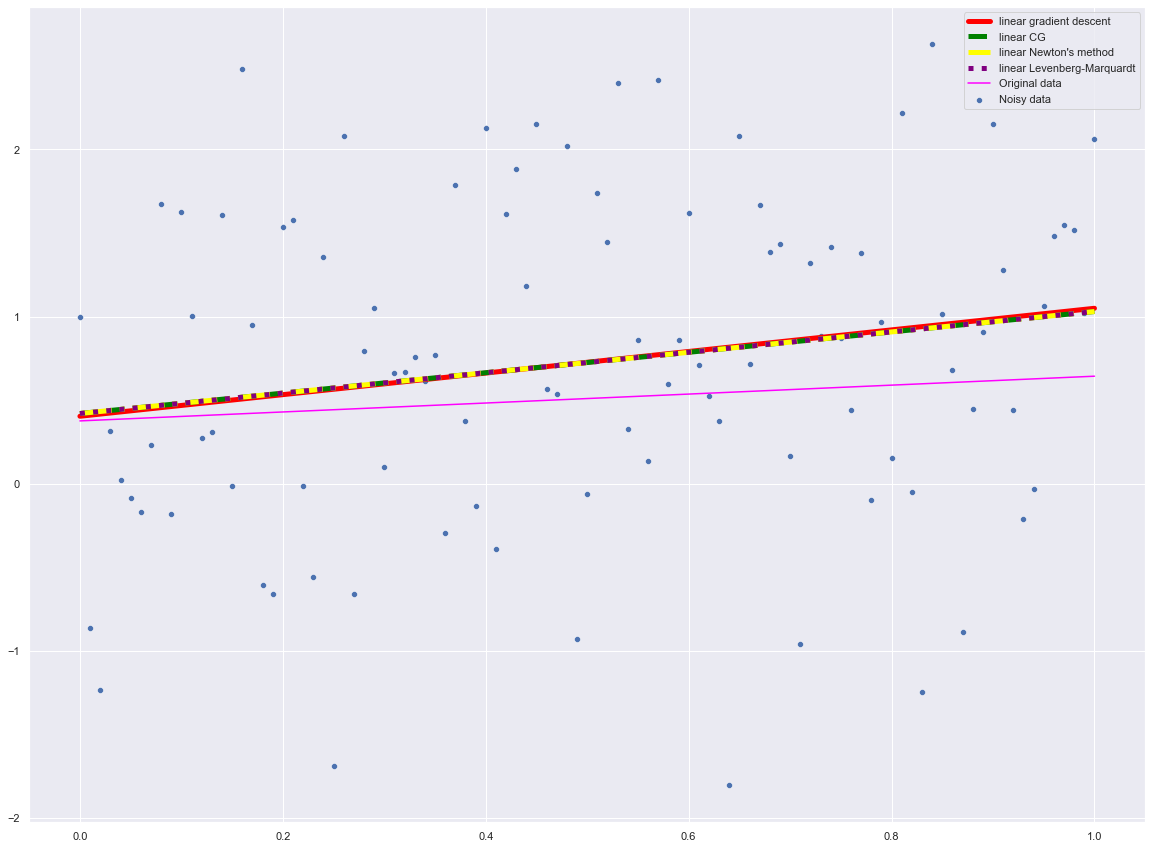

In [112]:
sns.scatterplot(y=yk,x=x,label="Noisy data")

#'-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
sns.lineplot(y=linear(x,*linearGradient[0]),x=x,dashes=[(10,5)], color="red",lw=5,label="linear gradient descent")
sns.lineplot(y=linear(x,*linearCG.x),x=x,ls="dashed", color="green",lw=5,label="linear CG")
sns.lineplot(y=linear(x,*linearNewton.x),x=x,ls="dashdot", color="yellow",lw=5,label="linear Newton's method")
sns.lineplot(y=linear(x,*linearLevenbergMarquardt.x),x=x,ls="dotted", color="purple",lw=5,label="linear Levenberg-Marquardt")

sns.lineplot(y=yk_original,x=x,color="fuchsia",label="Original data")

In [114]:
#a,b by Gradient Descent with rational aprox
rationalGradient = gradientDescent(x,yk,rationalSingle,prec,x0=[1,1])

#a,b by Conjugate Gradient Descent with rational aprox (contains in x prop)
rationalCG = opt.minimize(sum_squares, x0=[1, 1], args=(yk, x, rational), tol=prec, method='CG')

#a,b by Newton’s method with rational aprox (contains in x prop)
rationalNewton = opt.minimize(sum_squares, x0=[1, 1], args=(yk, x, rational),jac=jacobian(sum_squares), tol=prec, method='Newton-CG')

#a,b by Levenberg-Marquardt with rational aprox (contains in x prop)
#Counter value (real) and nfev are the same for another methods
LM_c=Counter(rational)
#We will find the number of iterations if we use counter for diff function
diff_c=Counter(diff)
rationalLevenbergMarquardt = opt.least_squares(diff_c, x0=[1, 1], args=(yk, x, LM_c), xtol=prec, method='lm')

print("grad: ",rationalGradient[0])
print("CG: ",rationalCG.x)
print("Newton’s: ",rationalNewton.x)
print("Levenberg-Marquardt: ",rationalLevenbergMarquardt.x)

print("grad: nit: ",rationalGradient[1],"   nfev: ",rationalGradient[2])
print("CG: nit: ",rationalCG.nit,"   nfev: ",rationalCG.nfev)
print("Newton’s: nit: ",rationalNewton.nit,"   nfev: ",rationalNewton.nfev)
print("Levenberg-Marquardt: nit:",diff_c.value(),"   nfev: ",LM_c.value())

grad:  [0.53288682179991, -0.48586725684417054]
CG:  [ 0.51997496 -0.50865883]
Newton’s:  [ 0.51948884 -0.509487  ]
Levenberg-Marquardt:  [ 0.51997031 -0.50866457]
grad: nit:  261    nfev:  1044
CG: nit:  8    nfev:  90
Newton’s: nit:  9    nfev:  13
Levenberg-Marquardt: nit: 31    nfev:  31


<AxesSubplot:>

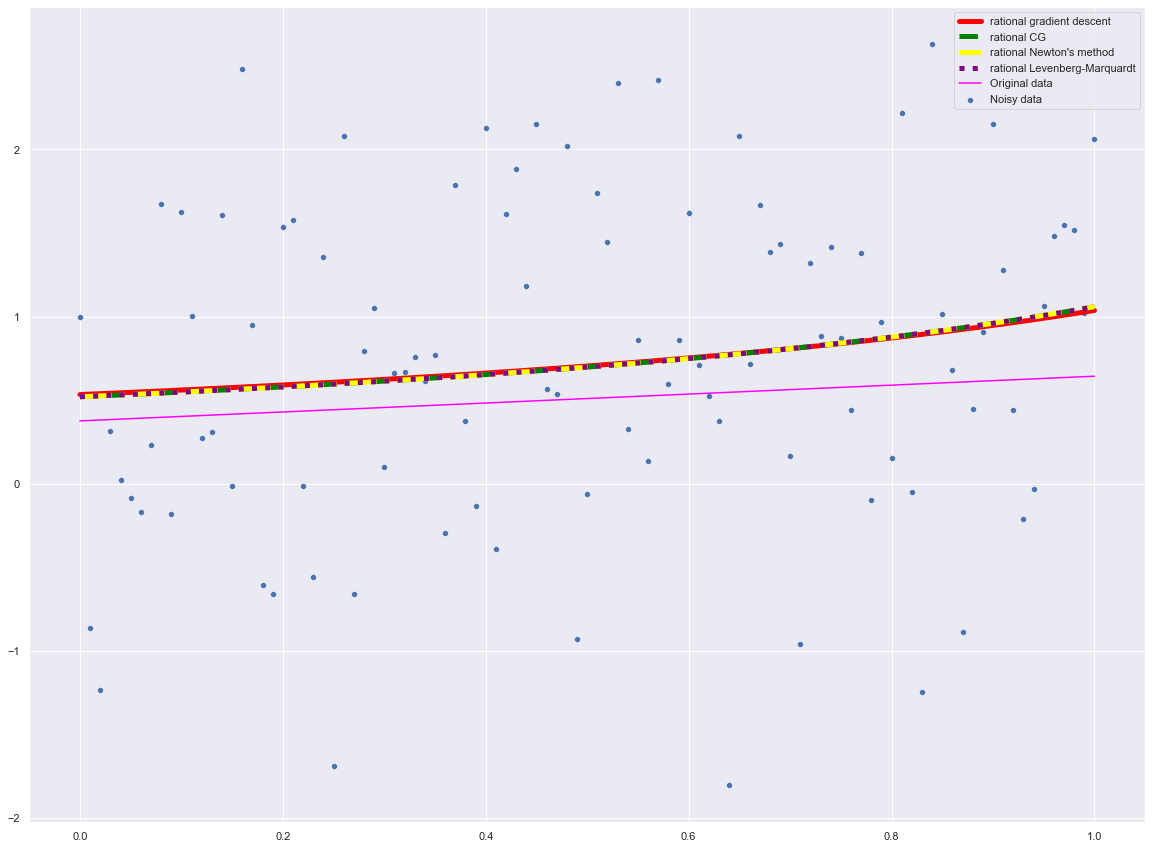

In [115]:
sns.scatterplot(y=yk,x=x,label="Noisy data")

#'-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
sns.lineplot(y=rational(x,*rationalGradient[0]),x=x,dashes=[(10,5)], color="red",lw=5,label="rational gradient descent")
sns.lineplot(y=rational(x,*rationalCG.x),x=x,ls="dashed", color="green",lw=5,label="rational CG")
sns.lineplot(y=rational(x,*rationalNewton.x),x=x,ls="dashdot", color="yellow",lw=5,label="rational Newton's method")
sns.lineplot(y=rational(x,*rationalLevenbergMarquardt.x),x=x,ls="dotted", color="purple",lw=5,label="rational Levenberg-Marquardt")

sns.lineplot(y=yk_original,x=x,color="fuchsia",label="Original data")